In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [37]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    # Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    def policy_fn(observation):
        max_action = Q[observation].argmax()
        e_greedy_policy = (epsilon/nA) * np.ones((nA), dtype=np.float)
        e_greedy_policy[max_action] = 1 - epsilon + epsilon/nA
        
        return e_greedy_policy
        
    return policy_fn

In [38]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episodes in range(num_episodes):
        if i_episodes % 50000 == 0: print(i_episodes)
            
        observation = env.reset()
        
        # Generate an episode using policy:
        observations_list = []
        actions_list = []
        rewards_list = []
        observations_list.append(observation)
        for t in range(100):
            probs = policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            observation, reward, done, _ = env.step(action)
            observations_list.append(observation)
            actions_list.append(action)
            rewards_list.append(reward)
            if done:
                break
                
        visited_state_actions = set()
        for start_t, (state, action) in enumerate(zip(observations_list, actions_list)):
            if (state, action) not in visited_state_actions:   # consider only first-visit (state, action)
                # Add current state as a new key
                # in returns_sum and returns_count if none:
                if (state, action) not in returns_sum:
                    returns_sum[(state, action)] = 0
                if (state, action) not in returns_count:
                    returns_count[(state, action)] = 0
                
                state_action_return = 0
                for t, t_reward in enumerate(rewards_list[start_t:]):
                    state_action_return += (discount_factor ** t) * t_reward
                returns_sum[(state, action)] += state_action_return
                returns_count[(state, action)] += 1
                
                visited_state_actions.add((state, action))
                
        for (state, action) in returns_sum:
            if state not in Q:
                Q[state] = {}
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
            
        # Update policy
#         policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, policy

In [39]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

0
50000
100000
150000
200000
250000
300000
350000
400000
450000


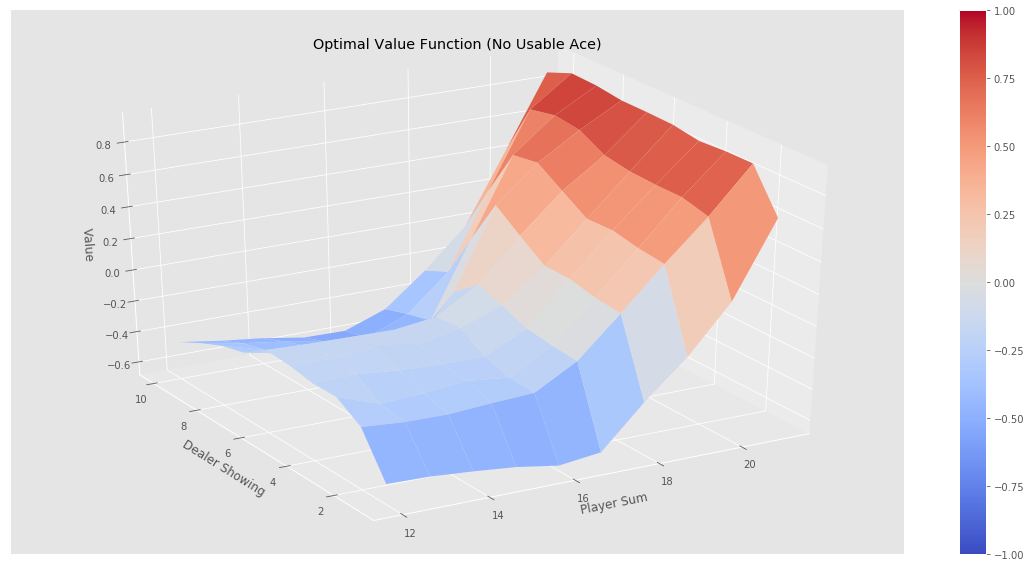

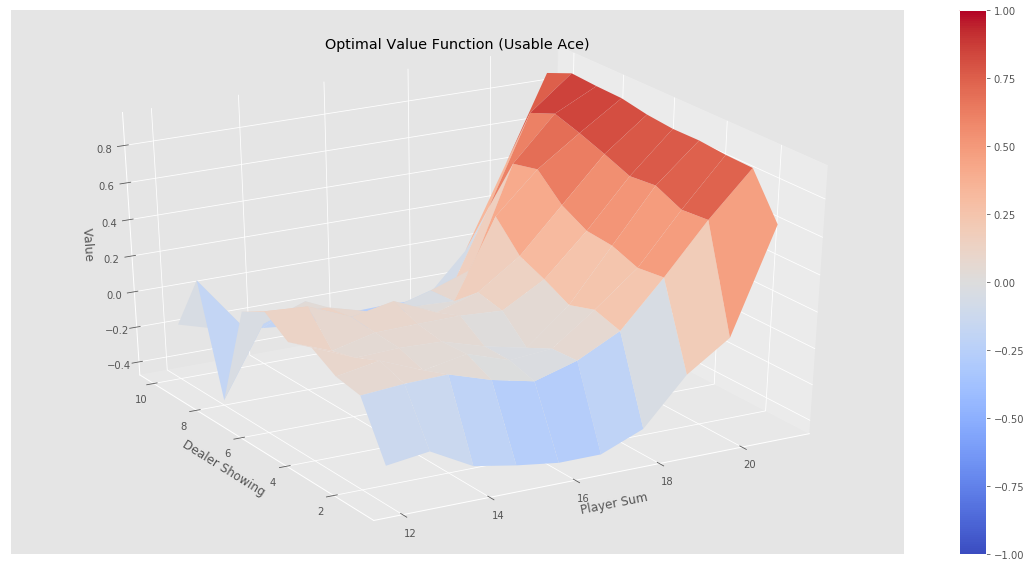

In [41]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")